In [1]:
from modules.data.temporal import *
from modules.data.mixed import *
from modules.utils.pso import *
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import numpy as np
import torch 
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
dataset = TemporalChunkedDataset("data/time_series/indrani_zeta_ca_no_zeroes.pickle")


Min Maxed Applied
Found Minimums: [3.98671096e-04 2.63890698e+03]
Found Max: [3.35322259e-01 1.15660328e+05]
Standardization to Input Parameters Applied
Found Mean Rates: [4.94051986e-03 5.43855361e+00 7.47319262e+03 5.58240092e+00
 5.13220676e-03]
With Std: [2.90661176e-03 2.58875028e+00 1.43908835e+03 2.59030686e+00
 2.82210229e-03]


In [7]:
print(dataset[0])

rates, input, output = dataset[0]
print(input.size())
print(output.size())

(tensor([-0.8488, -0.5005, -1.0289, -0.2520,  1.0611], dtype=torch.float64), tensor([[0.1151, 0.2705],
        [0.1161, 0.2730],
        [0.1173, 0.2754],
        [0.1184, 0.2778]], dtype=torch.float64), tensor([[0.1161, 0.2730],
        [0.1173, 0.2754],
        [0.1184, 0.2778],
        [0.1194, 0.2802]], dtype=torch.float64))
torch.Size([4, 2])
torch.Size([4, 2])


In [21]:
full_seq_dataset = TemporalDataset("data/time_series/indrani_zeta_ca_no_zeroes.pickle", standardize_inputs=False, min_max_scale=False)


torch.Size([2000, 2])


torch.Size([1999, 2])
tensor([1234.6470,  994.0442], dtype=torch.float64)


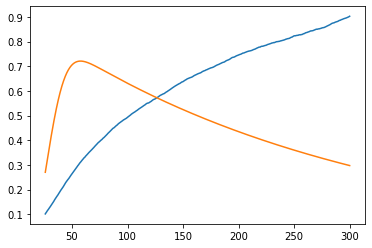

In [9]:
rates, input, output = full_seq_dataset[30]
print(input.size())
print(torch.sum(input, dim=0))
plt.plot(full_seq_dataset.times[:-1], input[:,:].numpy())

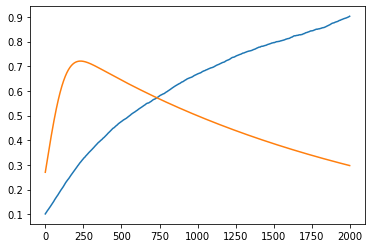

In [10]:
plt.plot(input.numpy())

In [11]:
# find 4 time points
time_points = [10,250,750,1750]
# process these into a new dataset, and then train
for t in time_points:
    data = generate_static_dataset(full_seq_dataset,t)
    data.write_to_csv("data/static/indrani_zeta_ca_t" +str(t) + ".csv")

In [12]:
print(full_seq_dataset.times[750])

128.80140070035017


In [13]:
def plot_trajectory_with_confidence_intervals(trajectories, confidence=0.68):
    num_trajectories, trajectory_length, feature_dim = trajectories.shape

    # Calculate mean and standard deviation for each time step
    mean_trajectory = np.mean(trajectories, axis=0)
    std_trajectory = np.std(trajectories, axis=0)
    # print(std_trajectory)

    # Calculate confidence intervals
    z_score = 1  # For 97% confidence interval (adjust as needed)
    lower_bound = mean_trajectory - z_score * std_trajectory #/ np.sqrt(num_trajectories)
    upper_bound = mean_trajectory + z_score * std_trajectory #/ np.sqrt(num_trajectories)
    # print(lower_bound)
    # print(upper_bound)
    # Plot mean trajectory
    time_points = np.arange(trajectory_length)
    plt.plot(time_points, mean_trajectory, label='Mean Trajectory')

    # Plot confidence intervals for each feature dimension
    for f in range(feature_dim):
        plt.fill_between(time_points, lower_bound[:, f], upper_bound[:, f],
                        alpha=0.3, label='2 Standard Deviations')

    # Set plot labels and title
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Trajectory with Confidence Intervals')

    # Show legend
    plt.legend()

    # Show the plot
    plt.show()

(1000, 2000, 2)


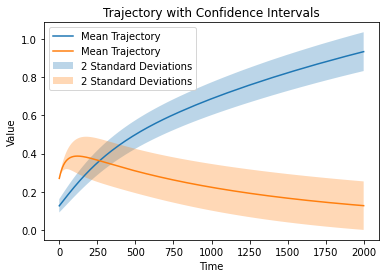

In [14]:
forPlotting = []
for output in full_seq_dataset.outputs:
    forPlotting.append(output.numpy())
forPlotting = np.array(forPlotting)
print(forPlotting.shape)
plot_trajectory_with_confidence_intervals(forPlotting)

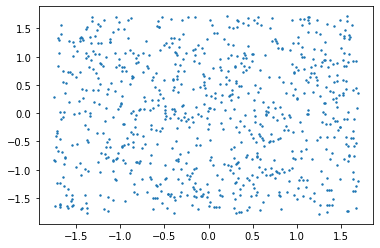

In [15]:
x = [r[3].numpy() for r in full_seq_dataset.rates]
y = [r[4].numpy() for r in full_seq_dataset.rates]
plt.scatter(x[:int(0.8*(len(x)))],y[:int(0.8*(len(x)))],s=2)

In [16]:
from sklearn.neighbors import NearestNeighbors

def find_nearest_neighbors(query_trajectory, trajectories, k):
    # Flatten the trajectories for nearest neighbor search
    flattened_trajectories = np.reshape(trajectories, (len(trajectories), -1))

    # Create a NearestNeighbors instance and fit the data
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(flattened_trajectories)

    # Reshape the query trajectory for nearest neighbor search
    query_flattened = np.reshape(query_trajectory, (1, -1))

    # Find the indices of nearest neighbors
    _, indices = nn.kneighbors(query_flattened)

    return indices.flatten()

In [17]:
find_nearest_neighbors(forPlotting[0], forPlotting, 5)

array([  0, 569, 122,  73,  59])

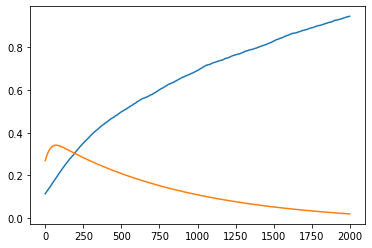

In [18]:
plt.plot(forPlotting[0])

In [19]:
plt.plot(forPlotting[1290])

IndexError: index 1290 is out of bounds for axis 0 with size 1000

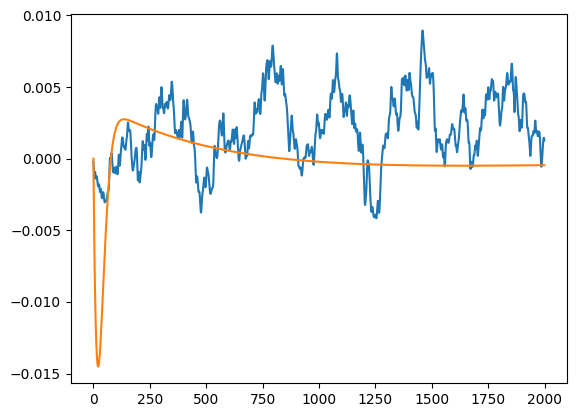

In [ ]:
plt.plot(forPlotting[1290] - forPlotting[0])

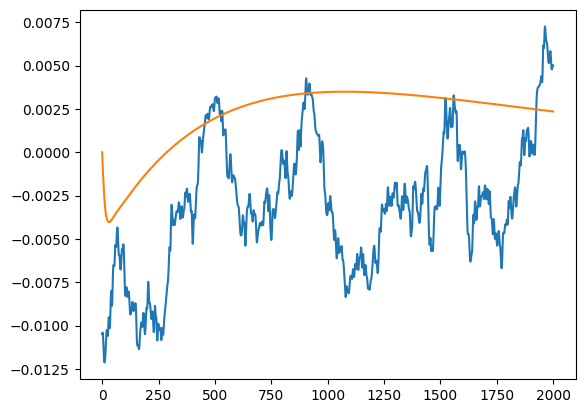

In [ ]:
plt.plot(forPlotting[0] - forPlotting[552])

In [ ]:
print(full_seq_dataset.rates[1290])

tensor([6.1361e-03, 9.6262e+00, 7.1413e+03, 5.0515e+00, 9.1834e-03],
       dtype=torch.float64)


In [ ]:
print(full_seq_dataset.rates[0])

tensor([5.7336e-03, 6.0856e+00, 9.8358e+03, 7.1113e+00, 9.1029e-03],
       dtype=torch.float64)


In [4]:
def get_data_inhomogenous(filename):
    # filename = 'your_file.txt'
    delimiter = '\t'  # Adjust this according to your file's format
    placeholder_value = np.nan  # Placeholder for missing values

    # Step 1: Read the file as a list of strings
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Step 2: Determine the maximum number of columns
    max_columns = max(len(line.split(delimiter)) for line in lines)

    # Step 4: Create a numpy array filled with the placeholder value
    data = np.empty((len(lines), max_columns))
    data.fill(placeholder_value)

    # Step 5: Iterate over the lines and fill the numpy array
    for i, line in enumerate(lines):
        values = line.strip().split(delimiter)
        data[i, :len(values)] = values

    # Print the resulting numpy array
    print(data.shape) 
    return data   

(2001, 5)


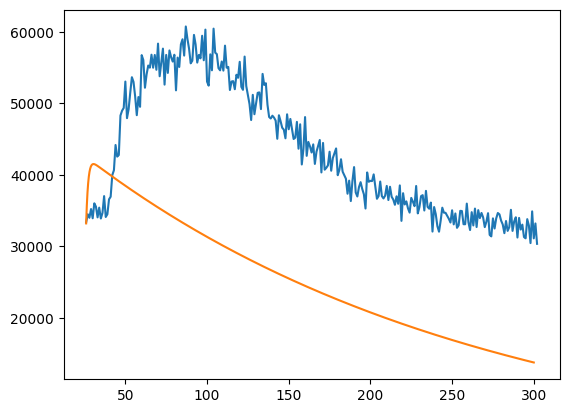

In [15]:
data_CD3z_46L_50k = np.loadtxt("data/John_Indrani_data/zeta_Ca_signal/test_data_experiments/CD3z_46L_50k.dat")
data_estimate = get_data_inhomogenous("data/John_Indrani_data/zeta_Ca_signal/estimate0.txt")
estimated_trajectories = data_estimate[1:,1:3]
times = data_estimate[1:,0]

plt.plot(data_CD3z_46L_50k[:,0], data_CD3z_46L_50k[:,1])
plt.plot(times, estimated_trajectories[:,1])

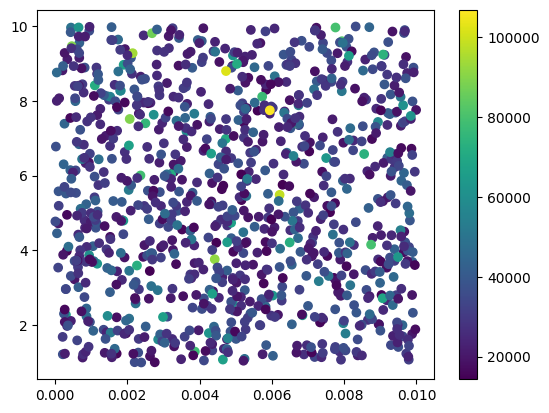

In [24]:
# full_seq_dataset.outputs

rates_array = []
outputs_array = []
for rate, output in zip(full_seq_dataset.rates , full_seq_dataset.outputs):
    rates_array.append(rate.numpy())
    outputs_array.append(output.numpy())

rates_array = np.array(rates_array) 
outputs_array = np.array(outputs_array)

# X,Y = np.meshgrid(rates_array[:,0], rates_array[:,1])
plt.scatter(rates_array[:,0], rates_array[:,1], c=outputs_array[:,750,1])
plt.colorbar()

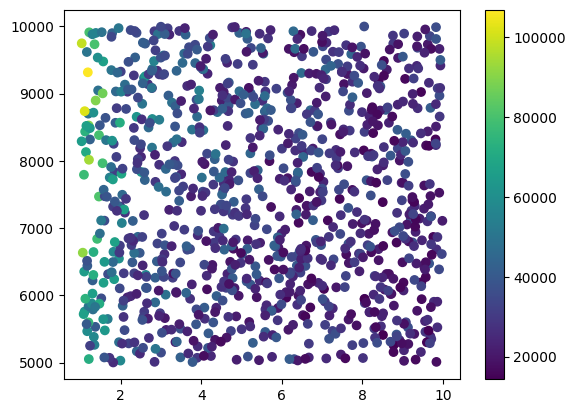

In [26]:
plt.scatter(rates_array[:,3], rates_array[:,2], c=outputs_array[:,750,1])
plt.colorbar()

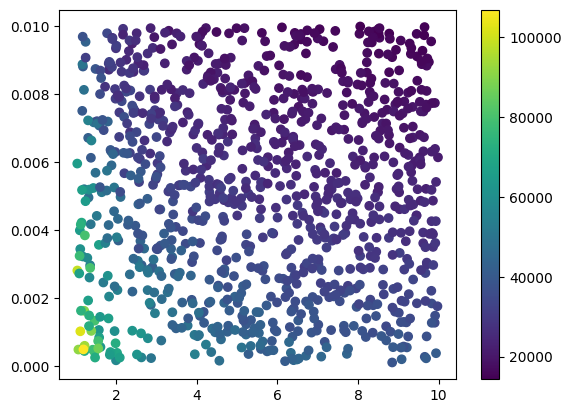

In [29]:
# generate some figures and images and save them to make a nice animation, so we can get an almost video like feeling for it.
for t in range(outputs_array.shape[1]):
    plt.scatter(rates_array[:,3], rates_array[:,4], c=outputs_array[:,750,1])
    plt.colorbar()

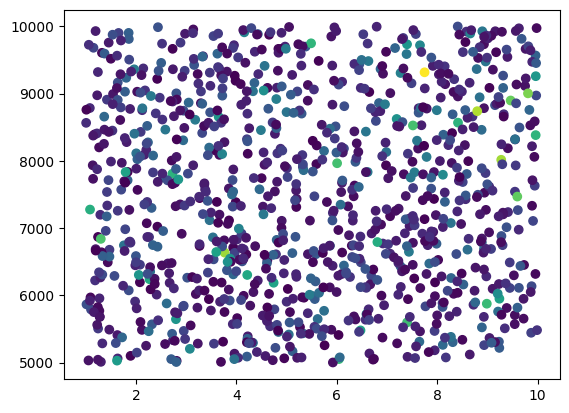

In [31]:
plt.scatter(rates_array[:,1], rates_array[:,2], c=outputs_array[:,1750,1])

#### PSO

In [ ]:
 # pso for hard trained model
l3Dataset100k = ABMDataset("data/static/l3p_100k.csv", root_dir="data/", standardize=True, norm_out=True)
sgModel = tc.load("model/l3p_100k_large_batch_normed.pt")
wt = np.loadtxt("pso/gmm_weight/l3p_t3.txt")
# wt = np.identity(sgModel.output_size)
# # print(wt)
x = np.zeros(sgModel.input_size)
y = np.array([12.4509,  6.9795, 9.06247, 93.9796, 31.9489, 84.5102, 53.8117, 72.7715, 47.3049])


estimates = []
for i in range(10):   
    gcost, gbest = StewartPSO(sgModel, y, wt, n_steps=50, n_particles=500, dataset=l3Dataset100k, standardize=False, normalize_out=True, batch=True)
    estimates.append(gbest)

estimates = np.array(estimates)
print("Surrogate Estimates:")
print(estimates)
print("Means:",np.mean(estimates,axis=0))
print("Var:",np.var(estimates, axis=0))
# from BioNetGMMFit:
bngmm_est = "data/BNGMMFit/model_estimates.csv"
print("BioNetGMMFit Estimates 200 Particles, 40 steps:")
data = np.genfromtxt(bngmm_est, delimiter=",", skip_header=True)
np.set_printoptions(suppress=True)
print("Means:", np.mean(data, axis=0))
print("Var:", np.var(data, axis=0))

In [20]:

def indrani_costss(x, surrogate, y, dataset, standardize=True, normalize=True, batch=False):
    costs = []
    if len(x.shape) < 2:
        thetaCopy = x
    else:
        thetaCopy = x.reshape(x.shape[0], -1)
    # print("ThetaCopy:", thetaCopy.shape)
    # print(thetaCopy)
    if standardize:
        thetaCopy = (thetaCopy - dataset.input_means) / dataset.input_stds

    input = tc.from_numpy(thetaCopy)
    if next(surrogate.parameters()).is_cuda:
        input = input.to(tc.device("cuda"))

    if batch:
        input = input.unsqueeze(dim=0)
    # print(" IM ALIVE")
    with tc.no_grad():
        output = surrogate(input).squeeze().cpu().numpy()

    if normalize:
        scale_factor = dataset.output_maxes - dataset.output_mins
        output = (output * scale_factor) + dataset.output_mins

    cost = np.matmul(output[:, 1] - y, (output[:, 1] - y).transpose())
    costs.append(cost)

    return np.array(costs)

def plot_confidence_intervals(x, confidence=0.95, title=None, labels=None):
    n_features = x.shape[1]
    n_samples = x.shape[0]
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    z_value = np.abs(np.random.standard_normal(x.shape)) * std
    intervals = np.percentile(x, [(1-confidence)*50, (1+confidence)*50], axis=0)

    plt.figure(figsize=(10, 6))
    for i in range(n_features):
        plt.plot([i, i], intervals[:, i], 'r-', lw=2)
        plt.plot(i, mean[i], 'bo', markersize=6)
    plt.xticks(range(n_features), labels)
    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.title(title)
    plt.grid(True)
    plt.savefig(title + ".png")

In [1]:

def indrani_costss(x, surrogate, y, dataset, standardize=True, normalize=True, batch=False):
    costs = []
    if len(x.shape) < 2:
        thetaCopy = x
    else:
        thetaCopy = x.reshape(x.shape[0], -1)
    # print("ThetaCopy:", thetaCopy.shape)
    # print(thetaCopy)
    if standardize:
        thetaCopy = (thetaCopy - dataset.input_means) / dataset.input_stds

    input = tc.from_numpy(thetaCopy)
    if next(surrogate.parameters()).is_cuda:
        input = input.to(tc.device("cuda"))

    if batch:
        input = input.unsqueeze(dim=0)
    # print(" IM ALIVE")
    with tc.no_grad():
        output = surrogate(input).squeeze().cpu().numpy()

    if normalize:
        scale_factor = dataset.output_maxes - dataset.output_mins
        output = (output * scale_factor) + dataset.output_mins

    cost = np.matmul(output[:, 1] - y, (output[:, 1] - y).transpose())
    costs.append(cost)

    return np.array(costs)

def plot_confidence_intervals(x, confidence=0.95, title=None, labels=None):
    n_features = x.shape[1]
    n_samples = x.shape[0]
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    z_value = np.abs(np.random.standard_normal(x.shape)) * std
    intervals = np.percentile(x, [(1-confidence)*50, (1+confidence)*50], axis=0)

    plt.figure(figsize=(10, 6))
    for i in range(n_features):
        plt.plot([i, i], intervals[:, i], 'r-', lw=2)
        plt.plot(i, mean[i], 'bo', markersize=6)
    plt.xticks(range(n_features), labels)
    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.title(title)
    plt.grid(True)
    plt.savefig(title + ".png")

def find_closest_index(arr, value):
    closest_index = np.abs(arr - value).argmin()
    return closest_index

# observed data is in the format of  (t,y)
def get_corresponding_y(observed_data, chosen_times):
    y = []
    for t in chosen_times:
        tdx = find_closest_index(observed_data[:,0], t)
        y.append(observed_data[tdx, 1])
    return y 

def multi_indrani_cost_fxn(x, surrogates, ys, datasets):
    # Reshape the input to match the expected shape
     
    mse = 0
    for i in range(len(surrogates)):
        surrogate = surrogates[i]
        dataset = datasets[i]
        y = ys[i]
        mse += indrani_costss(x, surrogate, y, dataset=dataset, batch=False)
    return mse
    
# Get the actual experimental data vectors


data_46L_50F_53V_85k = np.loadtxt("data/John_Indrani_data/zeta_Ca_signal/test_data_experiments/46L_50F_53V_85k.dat")
data_46L_50F_100k = np.loadtxt("data/John_Indrani_data/zeta_Ca_signal/test_data_experiments/46L_50F_100k.dat")
data_46L_53V_80k = np.loadtxt("data/John_Indrani_data/zeta_Ca_signal/test_data_experiments/46L_53V_80k.dat")
data_CD3z_46L_50k = np.loadtxt("data/John_Indrani_data/zeta_Ca_signal/test_data_experiments/CD3z_46L_50k.dat")
data_CD3z_mouse = np.loadtxt("data/John_Indrani_data/zeta_Ca_signal/test_data_experiments/CD3z_mouse_WT_33k.dat")
data_CD3z_human = np.loadtxt("data/John_Indrani_data/zeta_Ca_signal/test_data_experiments/human_cd3z_mean.dat")
t_max = 277
Y = [data_46L_50F_53V_85k[:t_max], data_46L_50F_100k[:t_max], data_46L_53V_80k[:t_max], data_CD3z_46L_50k[:t_max], data_CD3z_mouse[:t_max], data_CD3z_human[:t_max]] # big variable with all of the data in list format 
labels = ["46L_50F_53V", "46L_50F", "46L_53V", "CD3z_46L", "CD3z_mouse", "CD3z_human"] # for titles so we can plot them later with the predicted rate constants and outputs.
Y_dict = {}
for i in range(len(labels)):
    Y_dict[labels[i]] = Y[i]


# get surrogates
time_pts = [10, 250, 750, 1750]
# get their corresponding list of actual time-values
actual_times = full_seq_dataset.times[time_pts]
print(actual_times)
surrogates = []
prefix = "model/ixr_1k_zeta_ca_t"
suffix = "_res_batch_full.pt"

dataset_prefix = "data/static/indrani/indrani_zeta_ca_t"
dataset_suffix = ".csv"
datasets = []
for t in time_pts: 
    surrogates.append(tc.load(prefix + str(t) + suffix))
    datasets.append(ABMDataset(dataset_prefix + str(t) + dataset_suffix, root_dir="data/",standardize=True, norm_out=True))
# perform PSO across multiple time points (i.e each datasets y's) and surrogates.


# Define the bounds for a 5-dimensional problem
ixr_data = ABMDataset("data/static/indrani/indrani_zeta_ca_t750.csv", root_dir="data/", standardize=True, norm_out=True)
lower_bound = np.zeros(5)  # Lower bound array with all zeros
upper_bound = ixr_data.input_means + 6*ixr_data.input_stds  # Upper bound array with all 10,000s
bounds = (lower_bound, upper_bound)
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
num_particles = 500  # Number of particles in the swarm
dim = 5  # Dimensionality of the problem
optimizer = ps.single.GlobalBestPSO(n_particles=num_particles, dimensions=dim, bounds=bounds, options=options)
n_runs = 10
# MISSING KD!!!
rate_labels = ["k1", "k2", "C1", "C2", "g"]
for label, observed_data in Y_dict.items(): 
    # get the y observed values
    ys = get_corresponding_y(observed_data, actual_times)
    
    # multiple n_runs
    estimates = []
    for r in range(n_runs):
    # optimize multi-cost function with all the surrogates and the datasets
        cost, pos = optimizer.optimize(multi_indrani_cost_fxn, iters=10, surrogates=surrogates, ys=ys, datasets=datasets)
        estimates.append(pos)
    estimates = np.array(estimates)
    print(estimates.shape)
    plot_confidence_intervals(estimates, title=label,labels=rate_labels)


NameError: name 'np' is not defined

In [ ]:
t = 0
i = 0
for dat in Y:
    print("dataset:",i)
    print("t:", t)
    t+= np.sum(Y[3][:,0] - dat[:277,0])
    i+=1
print(t)
# min time point ~ 277.

dataset: 0
t: 0
dataset: 1
t: 0.0
dataset: 2
t: 0.0
dataset: 3
t: 0.0
dataset: 4
t: 0.0
dataset: 5
t: 0.0
0.0


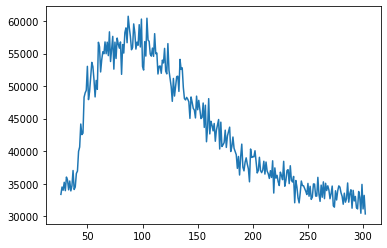

In [ ]:
plt.plot(data_CD3z_46L_50k[:,0],data_CD3z_46L_50k[:,1])
# print(data_CD3z_46L_50k)

In [ ]:
time_index = find_closest_index(data_CD3z_46L_50k[:,0], 128.8)
print(data_CD3z_46L_50k[time_index])
# print(data_CD3z_46L_50k[])


[  129.      48473.24219]


In [ ]:
 # pso for hard trained model
ixr_data = ABMDataset("data/static/indrani/indrani_zeta_ca_t750.csv", root_dir="data/", standardize=True, norm_out=True)
sgModel = tc.load("model/ixr3k_zeta_ca_t750_res_batch_full.pt")
x = np.zeros(sgModel.input_size)
y = data_CD3z_46L_50k[time_index,1]

pos = []
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
x = np.zeros((5,20))
# Define the bounds for a 5-dimensional problem
lower_bound = np.zeros(5)  # Lower bound array with all zeros
upper_bound = ixr_data.input_means + 6*ixr_data.input_stds  # Upper bound array with all 10,000s
bounds = (lower_bound, upper_bound)
n_estimates = 10
for i in range(n_estimates):   
    # Initialize the swarm optimizer
    num_particles = 3  # Number of particles in the swarm
    dim = 5  # Dimensionality of the problem
    optimizer = ps.single.GlobalBestPSO(n_particles=num_particles, dimensions=dim, bounds=bounds, options=options)

    # Perform the optimization
    cost, pos = optimizer.optimize(indrani_costss, iters=10, surrogate=sgModel, y=data_CD3z_46L_50k[time_index,1], dataset=ixr_data)

print("Surrogate Estimates:")
print(pos)
print("Means:",np.mean(pos,axis=0))
print("Var:",np.var(pos, axis=0))

2023-07-02 15:17:05,807 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Standardization to Input Parameters Applied
Original Mean Inputs: [4.95693817e-03 5.50389764e+00 7.46893493e+03 5.50635952e+00
 5.07432157e-03]
Original Stds: [2.89444027e-03 2.59283647e+00 1.42760721e+03 2.58733497e+00
 2.85315851e-03]
New Average Input Value: [ 6.02946264e-16 -4.74642547e-15  7.16937620e-15  2.36306213e-15
 -5.33719101e-15]
New Std Input Value: [1. 1. 1. 1. 1.]
max: 9998.776099064178
Normalization of Outputs
New Max: 1.0
New Min: 0.0


pyswarms.single.global_best: 100%|██████████|10/10, best_cost=1.56e+9
2023-07-02 15:17:05,877 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1564397574.1162527, best pos: [5.58543807e-04 1.06235373e+01 1.56089671e+04 1.41000484e+01
 3.59128782e-03]


ThetaCopy: (3, 5)
[[5.04786324e-03 1.05666636e+01 1.56092841e+04 1.41042180e+01
  1.72548653e-02]
 [1.77547575e-02 4.11256171e+00 3.00723387e+02 7.47970705e+00
  1.15347367e-02]
 [1.54426175e-02 1.25375203e+01 9.17162831e+03 2.87208010e+00
  6.33983359e-03]]
 IM ALIVE
ThetaCopy: (3, 5)
[[1.98766640e-02 1.06289113e+01 1.56100484e+04 1.43817729e+01
  5.70792439e-03]
 [1.54949815e-02 5.45599451e+00 1.78701567e+03 1.00373877e+01
  9.73803523e-03]
 [9.83742731e-03 1.26992671e+01 1.10969719e+04 5.15697730e+00
  1.10229626e-03]]
 IM ALIVE
ThetaCopy: (3, 5)
[[1.31313629e-02 1.06849341e+01 1.56107362e+04 1.46315724e+01
  6.41231389e-03]
 [1.46128750e-02 7.52450170e+00 3.85051309e+03 1.32114350e+01
  1.01997569e-02]
 [5.41441291e-03 1.27372589e+01 1.37896913e+04 9.60072930e+00
  1.96400658e-02]]
 IM ALIVE
ThetaCopy: (3, 5)
[[1.36235276e-02 1.07199878e+01 1.56111095e+04 1.47028459e+01
  2.25543963e-05]
 [2.14949985e-02 9.75702428e+00 6.75866594e+03 1.48834448e+01
  2.07446047e-02]
 [4.47068496e-0

In [ ]:
np.set_printoptions(floatmode='fixed')
print(pos)

[5.58543807e-04 1.06235373e+01 1.56089671e+04 1.41000484e+01
 3.59128782e-03]
